In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

## Dataset

In [4]:
df_train = pd.read_csv('Train.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            3013 non-null   object 
 1   summary                         2799 non-null   object 
 2   description                     3012 non-null   object 
 3   neighborhood_overview           1989 non-null   object 
 4   transit                         2089 non-null   object 
 5   host_since                      3013 non-null   object 
 6   host_location                   3008 non-null   object 
 7   host_about                      2238 non-null   object 
 8   host_response_rate              2664 non-null   object 
 9   host_acceptance_rate            2520 non-null   object 
 10  host_neighbourhood              2799 non-null   object 
 11  host_verifications              3013 non-null   object 
 12  neighbourhood_cleansed          30

In [7]:
df_train.head(2)

,name,summary,description,neighborhood_overview,transit,host_since,host_location,host_about,host_response_rate,host_acceptance_rate,host_neighbourhood,host_verifications,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month
0,Guest Quarters on Capitol Hill,The Guest Quarters on Capitol Hill is a garde...,The Guest Quarters on Capitol Hill is a garde...,the convenience and charm of being on Capitol ...,The Red Line and the Blue Line Metros are with...,2013-08-14,"Washington, District of Columbia, United States",We are a reservation service for many DC area ...,98%,52%,LeDroit Park,"['email', 'phone', 'reviews', 'kba']","Union Station, Stanton Park, Kingman Park",Washington,DC,20002,D.C.,"Washington, DC",US,United States,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,{},$195.00,NaN,2,3,90,2,90.0,10.0,10.0,10.0,10.0,10.0,8.0,f,strict,41,0.18
1,Private oasis. Top floor w/ 2 decks,"Top two floors, two bathrooms and two decks. M...","Top two floors, two bathrooms and two decks. M...",Adams Morgan is the most vibrant part of DC wh...,There is so many transportation options. Acros...,2012-01-23,"Washington, District of Columbia, United States","I have lived in DC for that past five years, b...",100%,100%,Adams Morgan,"['email', 'phone', 'facebook', 'reviews', 'kba']","Kalorama Heights, Adams Morgan, Lanier Heights",Washington,DC,20009,D.C.,"Washington, DC",US,United States,Apartment,Entire home/apt,2,1.5,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",$150.00,$50.00,2,2,1125,2,90.0,9.0,9.0,10.0,9.0,10.0,9.0,f,strict,1,0.41


## Data Cleaning

We need to transform some string features to numerical before creating some fancy plots

In [8]:
# cleaning features 
columns_to_transform = ['host_response_rate',
                       'host_acceptance_rate',
                        'price',
                        'cleaning_fee',
                        'host_since'
                        ]

In [9]:
df_train[columns_to_transform].isnull().sum()

host_response_rate       349
host_acceptance_rate     493
price                      0
cleaning_fee            1127
host_since                 0
dtype: int64

In [10]:
df_train.loc[:,'price'] = [i.replace(",","") for i in df_train.price]
df_train.loc[:,'price'] = [float(i.replace("$","")) for i in df_train.price]

#### host_since

In [11]:
df_train.loc[:,'host_since'] = pd.to_datetime(df_train['host_since'])

In [12]:
df_train.host_since.describe()

count                    3013
unique                   1252
top       2009-07-10 00:00:00
freq                       53
first     2008-08-08 00:00:00
last      2015-10-01 00:00:00
Name: host_since, dtype: object

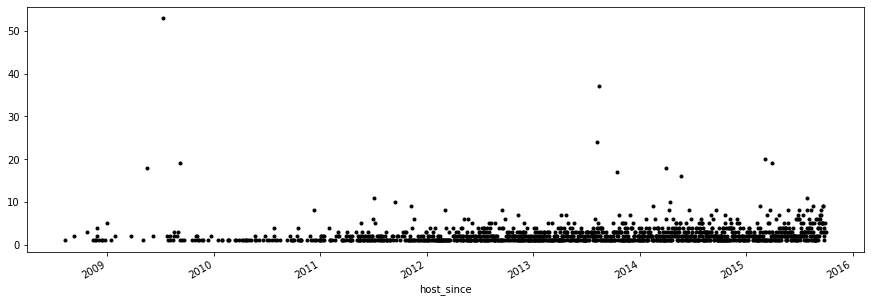

In [13]:
plt.figure(figsize=(15,5))
df_train.groupby('host_since').price.count().plot(style='k.')

In [14]:
df_test = pd.read_csv('Submission.csv')
df_test.loc[:,'host_since'] = pd.to_datetime(df_test['host_since'])
df_test.host_since.describe()

count                     618
unique                    462
top       2009-07-10 00:00:00
freq                        9
first     2008-09-07 00:00:00
last      2015-09-28 00:00:00
Name: host_since, dtype: object

Because we want transform feature to days we need to know the poind of ends. I used '2016-01-01' because all dates are in 2015 

In [15]:
# transform host_since to days
end_time_point = np.datetime64('2016-01-01')
df_train.loc[:, 'host_since'] = \
        (end_time_point - df_train.host_since).dt.days

#### host_response_rate, host_acceptance_rate
It has some NaNs, I treated them as a separate "new host" feature - so it can be used by the model

In [16]:
df_train.loc[:,'host_response_rate_nan'] = 0
df_train.loc[df_train.host_response_rate.isnull(),'host_response_rate_nan'] = 1
df_train.loc[:,'host_response_rate'] = df_train.host_response_rate.fillna('0%')
df_train.loc[:,'host_response_rate'] = [int(i.replace("%","")) for i in df_train.host_response_rate]

In [17]:
df_train.loc[:,'host_acceptance_rate_nan'] = 0
df_train.loc[df_train.host_acceptance_rate.isnull(),'host_acceptance_rate_nan'] = 1
df_train.loc[:,'host_acceptance_rate'] = df_train.host_acceptance_rate.fillna('0%')
df_train.loc[:,'host_acceptance_rate'] = [int(i.replace("%","")) for i in df_train.host_acceptance_rate]

#### cleaning_fee
transforming to numerical

In [18]:
df_train.loc[:,'cleaning_fee'] = df_train.cleaning_fee.fillna('0$')
df_train.loc[:,'cleaning_fee'] = [float(i.replace("$","")) for i in df_train.cleaning_fee]

## Explore

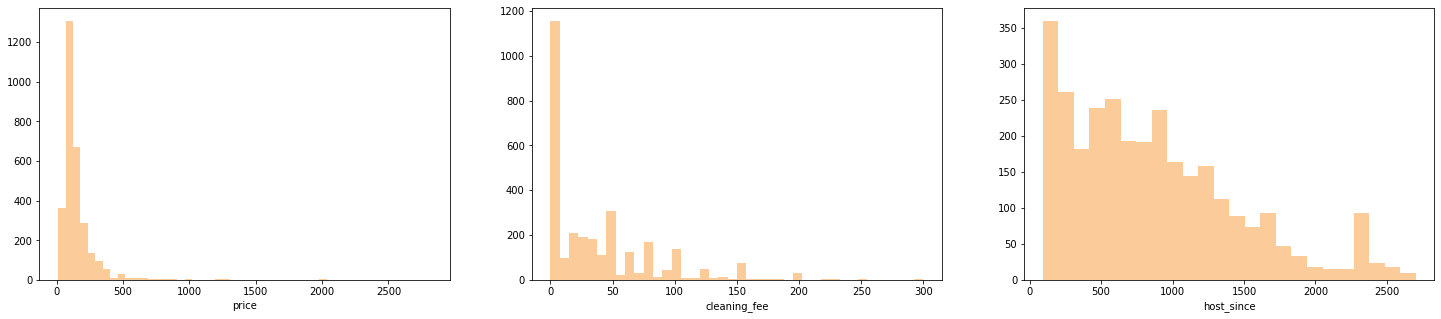

In [19]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(a=df_train["price"], hist=True, kde=False, rug=False,color='#f77f00')
plt.subplot(1,3,2)
sns.distplot(a=df_train["cleaning_fee"], hist=True, kde=False, rug=False,color='#f77f00')
plt.subplot(1,3,3)
sns.distplot(a=df_train["host_since"], hist=True, kde=False, rug=False,color='#f77f00')

We see that the price is skewed - we have relatively small numbers with few exceptions - the idea is to predict **log price**. The same goes with cleaning_fee, we potentially can transform it before feeding to ml.

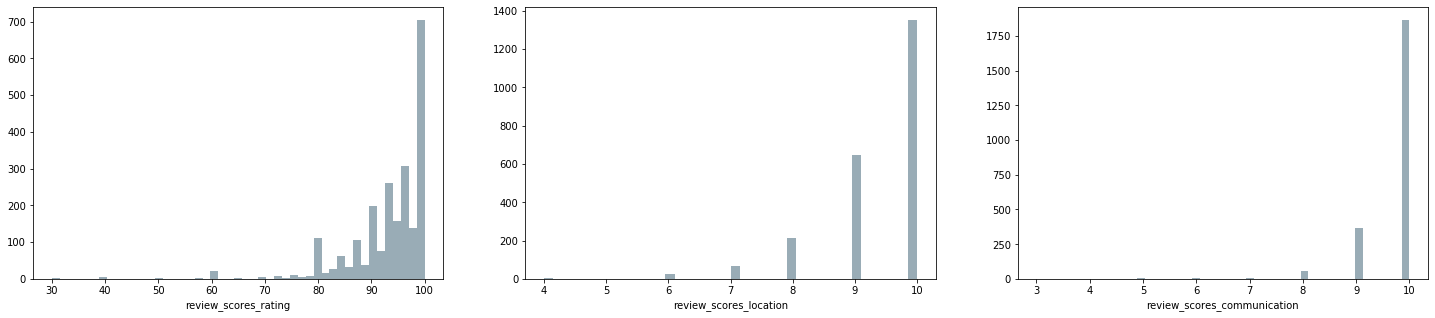

In [20]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(a=df_train["review_scores_rating"], hist=True, kde=False, rug=False,color='#003049')
plt.subplot(1,3,2)
sns.distplot(a=df_train["review_scores_location"], hist=True, kde=False, rug=False,color='#003049')
plt.subplot(1,3,3)
sns.distplot(a=df_train["review_scores_communication"], hist=True, kde=False, rug=False,color='#003049')

Ratings data is skewed again - we have a lot of top marks. 

I applied standard scaler to unify these ratings. Alternatively, we can do one hot encoding for them too (as for categorical features)

Text(0.5, 1.0, 'bedrooms vs price')

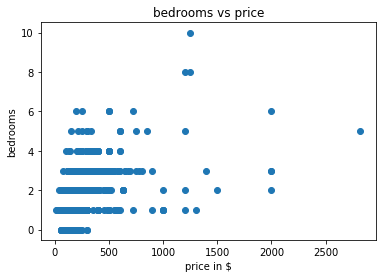

In [21]:
plt.scatter(df_train['price'],df_train['bedrooms'])
plt.ylabel('bedrooms')
plt.xlabel('price in $')
plt.title('bedrooms vs price')

Text(0.5, 1.0, 'Nnumber of reviews vs price')

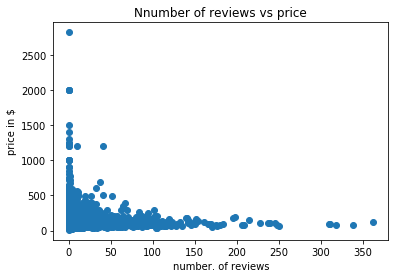

In [22]:
plt.scatter(df_train['number_of_reviews'],df_train['price'])
plt.ylabel('price in $')
plt.xlabel('number. of reviews')
plt.title('Nnumber of reviews vs price')

## Dealing with categorical features 

In [23]:
categorical_features = [
                        'host_neighbourhood',
                        'city',
                        'state',
                        'property_type',
                        'room_type',
                        'bed_type',
                        'instant_bookable',
                        'cancellation_policy'
                       ]
df_train[categorical_features].head(2)

,host_neighbourhood,city,state,property_type,room_type,bed_type,instant_bookable,cancellation_policy
0,LeDroit Park,Washington,DC,Apartment,Entire home/apt,Real Bed,f,strict
1,Adams Morgan,Washington,DC,Apartment,Entire home/apt,Real Bed,f,strict


In [24]:
df_train[categorical_features].isnull().sum()

host_neighbourhood     214
city                     0
state                    0
property_type            1
room_type                0
bed_type                 0
instant_bookable         0
cancellation_policy      0
dtype: int64

#### host_neighbourhood

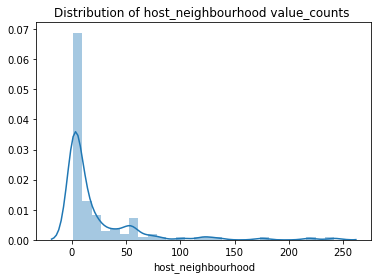

In [25]:
plt.title('Distribution of host_neighbourhood value_counts ')
sns.distplot(df_train.host_neighbourhood.value_counts())

Clearly, most of the neighbourhoods are not that popular. Let's create a one-hot encoding for the modt popular neighborhoods (so that the model will learn the difference). 

In [26]:
value_counts_host_neighbourhood = df_train.host_neighbourhood.value_counts()
sum(value_counts_host_neighbourhood > 75)

8

In [27]:
top_category_host_neighbourhood = value_counts_host_neighbourhood[value_counts_host_neighbourhood > 75].index

In [28]:
top_category_host_neighbourhood

Index(['Capitol Hill', 'Columbia Heights', 'Dupont Circle', 'Logan Circle',
       'U Street Corridor', 'Adams Morgan', 'Near Northeast/H Street Corridor',
       'Shaw'],
      dtype='object')

In [29]:
df_train.loc[:,'host_neighbourhood'] = df_train.host_neighbourhood.fillna('unknown')

In [30]:
host_neighbourhood_one_hot_top = pd.get_dummies(df_train.host_neighbourhood)[top_category_host_neighbourhood]

In [31]:
host_neighbourhood_one_hot_top.head(4)

,Capitol Hill,Columbia Heights,Dupont Circle,Logan Circle,U Street Corridor,Adams Morgan,Near Northeast/H Street Corridor,Shaw
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1


In [32]:
df_train = pd.concat([df_train,host_neighbourhood_one_hot_top],axis = 1).drop(columns = 'host_neighbourhood')

####  city
The same motivation goes here - Washington is in the majority. Set the other options as additional parameter

In [33]:
df_train.city.value_counts().head(5)

Washington          2936
Washington, D.C.      51
Silver Spring          6
Takoma Park            5
Mount Rainier          5
Name: city, dtype: int64

In [34]:
df_train.city.unique()

array(['Washington', 'Washington, D.C.', 'Silver Spring', 'Mount Rainier',
       'New York', 'Columbia Heights, middle of DC!', 'Washington ',
       'Arlington', 'Takoma Park', 'Dupont Circle', 'Annapolis',
       'Hyattsville', 'Capitol Hill, Washington', 'Adams Morgan'],
      dtype=object)

In [ ]:
df_train.loc[~df_train['city'].str.lower().str.contains('washington'),'city_one_hot'] = 1
df_train.loc[:,'city_one_hot'] = df_train.city_one_hot.fillna(0)
df_train = df_train.drop(columns = 'city')

#### state
same, choose all that are not from DC

In [36]:
df_train.state.value_counts().head(5)

DC               2992
MD                 18
NY                  1
VA                  1
Washington DC       1
Name: state, dtype: int64

In [37]:
# I chose all not from DC state 
df_train.loc[~df_train['state'].str.lower().str.contains('dc'),'state_one_hot'] = 1
df_train.loc[:,'state_one_hot'] = df_train.state_one_hot.fillna(0)
df_train = df_train.drop(columns = 'state')

#### property_type
Perform one-hot encoding with Apartment (as the most popular) as (0,0), House - (1,0), any other - (0,1)

In [38]:
df_train.property_type.value_counts().head(5)

Apartment          1853
House               950
Condominium          69
Townhouse            61
Bed & Breakfast      44
Name: property_type, dtype: int64

In [39]:
df_train.loc[:,'property_type'] = df_train.property_type.fillna('unknown')

In [40]:
df_train.loc[df_train['property_type'] == 'House','property_type_house'] = 1
df_train.loc[:,'property_type_house'] = df_train.property_type_house.fillna(0)

In [41]:
value_counts_property_type = df_train.property_type.value_counts()
low_category_property_type = value_counts_property_type[value_counts_property_type < 500].index

In [42]:
df_train.loc[df_train['property_type'].isin(low_category_property_type),'property_type_other'] = 1
df_train.loc[:,'property_type_other'] = df_train.property_type_other.fillna(0)

In [43]:
df_train = df_train.drop(columns = 'property_type')

#### room_type
Same motivation as in the previous one

In [44]:
df_train.room_type.value_counts().head(5)

Entire home/apt    1968
Private room        964
Shared room          81
Name: room_type, dtype: int64

In [45]:
room_type_one_hot = pd.get_dummies(df_train.room_type,drop_first=True)
df_train = pd.concat([df_train,room_type_one_hot],axis = 1).drop(columns = 'room_type')

#### bed_type
Anything other than "Real Bed" is set to 1

In [46]:
df_train.bed_type.value_counts().head(5)

Real Bed         2890
Futon              47
Pull-out Sofa      36
Airbed             31
Couch               9
Name: bed_type, dtype: int64

In [47]:
df_train.loc[df_train['bed_type'] != 'Real Bed','bed_type_not_real_bed'] = 1
df_train.loc[:,'bed_type_not_real_bed'] = df_train.bed_type_not_real_bed.fillna(0)

In [48]:
df_train = df_train.drop(columns = 'bed_type')

#### instant_bookable
averything other than False is (1)

In [49]:
df_train.instant_bookable.value_counts().head(5)

f    2697
t     316
Name: instant_bookable, dtype: int64

In [50]:
df_train.loc[df_train['instant_bookable'] != 'f','instant_bookable_not_f'] = 1
df_train.loc[:,'instant_bookable_not_f'] = df_train.instant_bookable_not_f.fillna(0)

In [51]:
df_train = df_train.drop(columns = 'instant_bookable')

#### cancellation_policy
one-hot encoding, all has its separate feature (as it may be important). "flexible" is (0,0,0) as the most popular

In [52]:
df_train.cancellation_policy.value_counts().head(5)

flexible           1093
strict              978
moderate            889
super_strict_30      53
Name: cancellation_policy, dtype: int64

In [53]:
cancellation_policy_one_hot = pd.get_dummies(df_train.cancellation_policy,drop_first=True)
df_train = pd.concat([df_train,cancellation_policy_one_hot],axis = 1).drop(columns = 'cancellation_policy')

### JSON to features
Two colums has a weird format of features, let's analyze them

#### host_verifications
Parse string to understandable format. Then I performed one-hot encoding for each "inner feature"

In [55]:
df_train.loc[:,'host_verifications'] = [i.replace('[','') for i in df_train.host_verifications]
df_train.loc[:,'host_verifications'] = [i.replace(']','') for i in df_train.host_verifications]
df_train.loc[:,'host_verifications'] = [i.replace("'",'') for i in df_train.host_verifications]
df_train.loc[:,'host_verifications'] = [i.replace(" ",'') for i in df_train.host_verifications]

In [56]:
df_train.loc[:,'host_verifications_copy'] = [i.split(',') for i in df_train.host_verifications]

In [57]:
row_host_verifications = []

In [58]:
# get all values in column
for index, row in df_train.iterrows():
    for i in row.host_verifications_copy:
        row_host_verifications.append(i)

In [59]:
np.unique(row_host_verifications)

array(['', 'email', 'facebook', 'google', 'jumio', 'kba', 'linkedin',
       'manual_offline', 'manual_online', 'phone', 'reviews', 'sent_id'],
      dtype='<U14')

In [60]:
host_verifications_values = [
      'email',
      'facebook',
      'google',
      'jumio',
      'kba',
      'linkedin',
       'manual_offline',
      'manual_online',
      'phone',
      'reviews',
      'sent_id'
    ]

In [61]:
df_train.host_verifications.isnull().sum()

0

In [62]:
def create_one_hot_feature_by_key(df_col,keys):
    one_hot = []
    for key in keys:
        one_hot_prt = df_col.str.contains(key)*1
        one_hot.append(one_hot_prt)
    return one_hot

In [63]:
host_verifications_one_hot = create_one_hot_feature_by_key(df_train.host_verifications,host_verifications_values)

In [64]:
df_train = df_train.join(pd.concat(host_verifications_one_hot,keys=[value for value in host_verifications_values],axis = 1))

In [65]:
df_train = df_train.drop(columns = ['host_verifications','host_verifications_copy'])

#### amenities

In [66]:
df_train.loc[:,'amenities'] = [i.replace('{','') for i in df_train.amenities]
df_train.loc[:,'amenities'] = [i.replace('}','') for i in df_train.amenities]
df_train.loc[:,'amenities'] = [i.replace("'",'') for i in df_train.amenities]
df_train.loc[:,'amenities'] = [i.replace(" ",'') for i in df_train.amenities]
df_train.loc[:,'amenities'] = [i.replace('"','') for i in df_train.amenities]

In [68]:
df_train.loc[:,'amenities_copy'] = [i.split(',') for i in df_train.amenities]

In [69]:
row_amenities = []
for index, row in df_train.iterrows():
    for i in row.amenities_copy:
        row_amenities.append(i)

In [70]:
row_amenities = pd.DataFrame(row_amenities,columns = ['amenities'])

In [71]:
row_amenities.amenities.value_counts()

AirConditioning            2883
Heating                    2863
WirelessInternet           2855
Kitchen                    2785
Washer                     2450
Dryer                      2425
SmokeDetector              2404
Internet                   2378
Essentials                 2321
TV                         2261
Shampoo                    1601
CableTV                    1523
FireExtinguisher           1489
Family/KidFriendly         1439
CarbonMonoxideDetector     1335
FirstAidKit                 940
FreeParkingonPremises       891
ElevatorinBuilding          842
Gym                         493
Petsliveonthisproperty      491
Buzzer/WirelessIntercom     421
IndoorFireplace             407
SafetyCard                  398
PetsAllowed                 374
Doorman                     345
Dog(s)                      332
WheelchairAccessible        268
Pool                        256
Breakfast                   227
Cat(s)                      188
SuitableforEvents           165
HotTub  

**Comment**: we have a lot of options to try here. I merged the most popular amenities together, as they are present almost always. Now any "rare" amenity is considered as a plus (the row will have 1 in this column). Finally, eache "intermediate" amenity has its ofn feature vector.

In [72]:
amenities_value_counts = row_amenities.amenities.value_counts()
rare_amenities_name = amenities_value_counts[amenities_value_counts<500].index
midle_popular_amenities_name = amenities_value_counts[amenities_value_counts.between(500,2500,inclusive = True)].index

In [73]:
rare_amenities_name = [key_value for key_value in rare_amenities_name if not key_value == '']
midle_popular_amenities_name = [key_value for key_value in midle_popular_amenities_name if not key_value == '']

In [74]:
amenities_values = [
    'Internet',
    'WirelessInternet',
    'AirConditioning',
    'Kitchen',
    'Buzzer/WirelessIntercom',
    'Heating',
    'Family/KidFriendly',
    'Washer',
    'Dryer',
    'SmokeDetector', 
    'CarbonMonoxideDetector',
    'FireExtinguisher',
    'Essentials', 
    'Shampoo',
    'TV',
    'CableTV',
    'Petsliveonthisproperty',
    'WheelchairAccessible',
    'PetsAllowed',
    'IndoorFireplace',
    'FreeParkingonPremises',
    'Doorman',
    'Gym',
    'ElevatorinBuilding',
    'FirstAidKit',
    'Dog(s)',
    'Breakfast',
    'HotTub',
    'SafetyCard',
    'Pool', 
    'Cat(s)',
    'SuitableforEvents',
    'SmokingAllowed',
    'Otherpet(s)',
    'Washer/Dryer'
]

In [75]:
amenities_one_hot = create_one_hot_feature_by_key(df_train.amenities,amenities_values)

/home/yevheniia/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [76]:
amenities_one_hot = pd.concat(amenities_one_hot,keys=[value for value in amenities_values],axis = 1)

In [77]:
midle_popular_amenities_one_hot = amenities_one_hot[midle_popular_amenities_name]

In [82]:
rare_amenities_one_hot = amenities_one_hot[rare_amenities_name].apply(lambda x: (x.sum() != 0)*1 ,axis = 'columns')

In [83]:
midle_popular_amenities_one_hot.loc[:,'other_rare_amenities'] = rare_amenities_one_hot.copy()

In [84]:
midle_popular_amenities_one_hot = midle_popular_amenities_one_hot.add_suffix('_amenities')

In [85]:
df_train = df_train.join(midle_popular_amenities_one_hot)

In [86]:
df_train = df_train.drop(columns = ['amenities','amenities_copy'])

In [87]:
columns_train = df_train.describe().columns

In [89]:
df_train.loc[:,'id_number'] = df_train.index

In [90]:
df_train = df_train.set_index(['id_number','name'])

### Scaling
Scale features to the same basis. I saved the list to perform the same operations for unknown data.

In [91]:
columns_to_scale_train = [
    'host_since',
    'host_response_rate',
    'host_acceptance_rate',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'cleaning_fee',
    'guests_included',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'calculated_host_listings_count',
    'reviews_per_month'
]  

In [92]:
# scale non binary features
scaler_train = StandardScaler()

In [93]:
scaler_train.fit(df_train.loc[:, columns_to_scale_train])
df_train.loc[:, columns_to_scale_train] = scaler_train.transform(df_train.loc[:, columns_to_scale_train])

In [94]:
df_train.price.describe()

count    3013.000000
mean      150.573183
std       147.364464
min        10.000000
25%        85.000000
50%       115.000000
75%       165.000000
max      2822.000000
Name: price, dtype: float64

In [95]:
final_train_df = df_train[columns_train].fillna(0)

In [96]:
final_train_df.loc[:, 'price_log'] = np.log(final_train_df['price'])

In [97]:
final_train_df.to_csv('final_train_df.csv')

In [98]:
from sklearn.externals.joblib import dump, load
dump(scaler_train, 'std_scaler.bin', compress=True)

/home/yevheniia/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['std_scaler.bin']

### Preprocess submission dataset

In [99]:
from preprocess import data_preprocess

In [100]:
df_submission = pd.read_csv('Submission.csv')

In [101]:
df_submission_preprocess = data_preprocess(df_submission)

/home/yevheniia/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/home/yevheniia/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/yevheniia/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self

In [102]:
scaler_train.fit(df_submission_preprocess.loc[:, columns_to_scale_train])
df_submission_preprocess.loc[:, columns_to_scale_train] = scaler_train.transform(df_submission_preprocess.loc[:, columns_to_scale_train])

In [105]:
df_submission_preprocess.to_csv('Submission_preprocess.csv',index=False)